In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openmc
from matplotlib.colors import LogNorm
from numpy.polynomial.legendre import Legendre

pitch = 1.26

# ================
# Extract Tallies
# ================
# Load tally results from OpenMC statepoint file
statepoint = openmc.StatePoint("statepoint.1000.h5")  # Adjust batch number as needed

# -----------
# Mesh Tally
# -----------
# Extract the tally of interest
tally = statepoint.get_tally(name="flux_at_right_boundary")

# Get tally data
flux = tally.mean  # The flux values (mean)
flux_uncertainty = tally.std_dev  # The standard deviation
flux[np.where(flux <= flux_uncertainty)] = 0

# Extract filters for normalization
mesh_filter = tally.find_filter(openmc.MeshFilter)
energy_filter = tally.find_filter(openmc.EnergyFilter)
angle_filter = tally.find_filter(openmc.AzimuthalFilter)

E_min = energy_filter.bins[0][0]
E_max = energy_filter.bins[-1][-1]

Ny = len(mesh_filter.bins)
NE = len(energy_filter.bins)
Nω = len(angle_filter.bins)

flux = flux[:, 0, 0].reshape([Ny, Nω, NE], order='C')

# Get bin widths for normalization
delta_y = pitch/Ny
delta_omega = angle_filter.bins[0][1] - angle_filter.bins[0][0]
delta_E = np.diff(energy_filter.bins)[:, 0]  # Energy group widths

# Normalize the flux
flux_normalized = flux / (delta_y * delta_omega * delta_E[np.newaxis, np.newaxis, :])

# Select a representative slice for each variable
# Example: fixing energy group, angle, or y-axis index
energy_index = len(delta_E) // 4  # Representative energy group (middle of the spectrum)
angle_index = len(angle_filter.bins) // 2  # Representative angle (middle bin)
mesh_index = Ny // 2  # Representative y-axis index (middle of the mesh)

# ---------------
# Moment Tallies
# ---------------

tally = statepoint.get_tally(name="flux_moment_at_right_boundary")

moments = tally.mean  # The flux values (mean)
moments_uncertainty = tally.std_dev  # The standard deviation

# moments[np.where(moments <= moments_uncertainty)] = 0

# Get the order of the Legendre expansions in space and angle (I, J max index)
I = tally.find_filter(openmc.SpatialLegendreFilter).order + 1
J = tally.find_filter(openmc.LegendreFilter).order + 1

# Reshape the moments
moments = moments[:, 0, 0].reshape([I, J, NE], order='C')

# -------------------------
# Now Reconstruct the Flux
# -------------------------

# Now reconstruct the spatial flux (evaluate it at the same points as the mesh tally for easy comparison)
reconstructed_flux = np.zeros((Ny, Nω, NE))

legendre_coefficients = np.zeros((I, J))
for i in range(I):
    for j in range(J):
        legendre_coefficients[i,j] = (2*i + 1)*(2*j + 1)/(pitch*np.pi)

moments = legendre_coefficients[:, :, np.newaxis] * moments

bins = np.linspace(-pitch / 2, pitch / 2, Ny + 1)
y_vals = (bins[:-1] + bins[1:]) / 2  # Correctly compute the centers of the bins
ω_vals = (angle_filter.values[:-1] + angle_filter.values[1:]) / 2

y_mesh, angle_mesh = np.meshgrid(y_vals, ω_vals, indexing='ij')

for E_bin in range(NE):
    # Ensure you are using the complete coefficient matrix for the 2D polynomial evaluation
    reconstructed_flux[:, :, E_bin] = np.polynomial.legendre.legval2d((2 * y_mesh) / pitch, angle_mesh*2/np.pi, moments[:, :, E_bin])/delta_E[E_bin]

In [2]:
def plot_flux(flux, energy_index, angle_index, mesh_index):
    # Plot a 2D slice with energy fixed
    flux_energy_slice = flux[:, :, energy_index]  # Fix energy
    print(flux_energy_slice.shape)
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_energy_slice.T, origin="lower", extent=[-pitch/2, pitch/2, -np.pi/2, np.pi/2], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.xlabel("y-position")
    plt.ylabel("Angle (rad)")
    plt.title(f"Flux Slice at Energy {(energy_filter.bins[energy_index][1] - energy_filter.bins[energy_index][0])/2} eV")
    plt.show()

    # Plot a 2D slice with angle fixed
    flux_angle_slice = flux[:, angle_index, :]  # Fix angle
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_angle_slice.T, origin="lower", extent=[-pitch/2, pitch/2, E_min, E_max], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.ylabel("Energy (eV)")
    plt.xlabel("y-position")
    plt.title(f"Flux Slice at Angle {(angle_filter.bins[angle_index][1] - angle_filter.bins[angle_index][0])/2} radians")
    plt.show()

    # Plot a 2D slice with y fixed
    flux_y_slice = flux[mesh_index, :, :]  # Fix y location
    plt.figure(figsize=(8, 6))
    plt.imshow(flux_y_slice.T, origin="lower", extent=[-np.pi/2, np.pi/2, E_min, E_max], aspect="auto",norm=LogNorm())
    plt.colorbar(label="Flux (normalized)")
    plt.ylabel("Energy (eV)")
    plt.xlabel("Angle (rad)")
    plt.title(f"Flux Slice at y-position Index {mesh_index}")
    plt.show()

(50, 20)


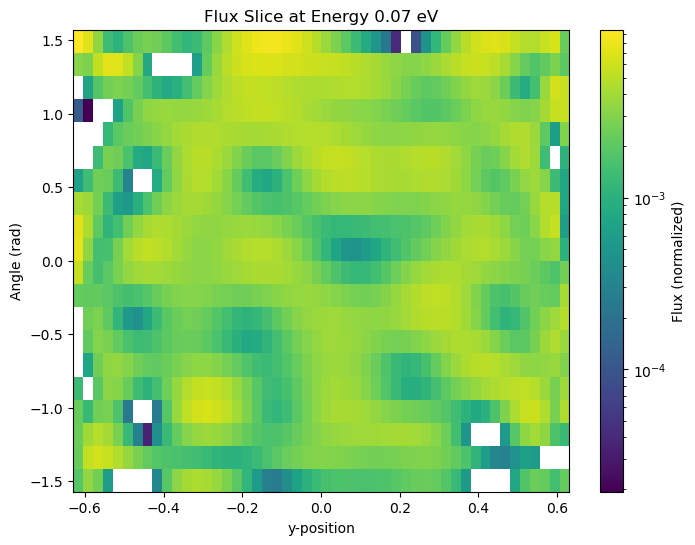

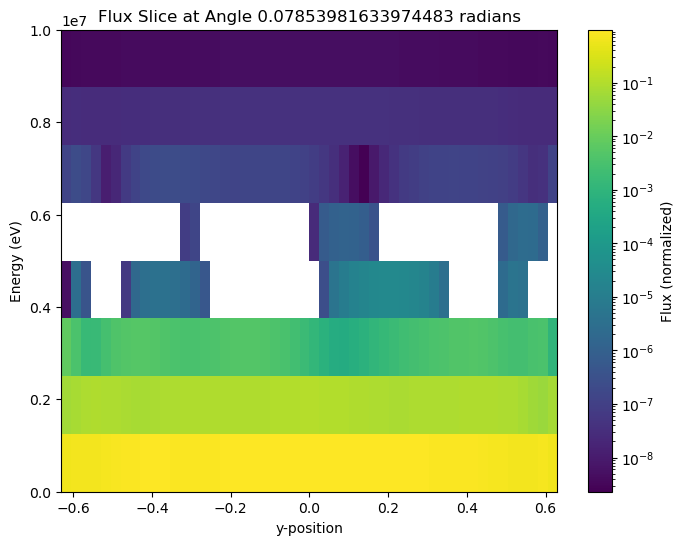

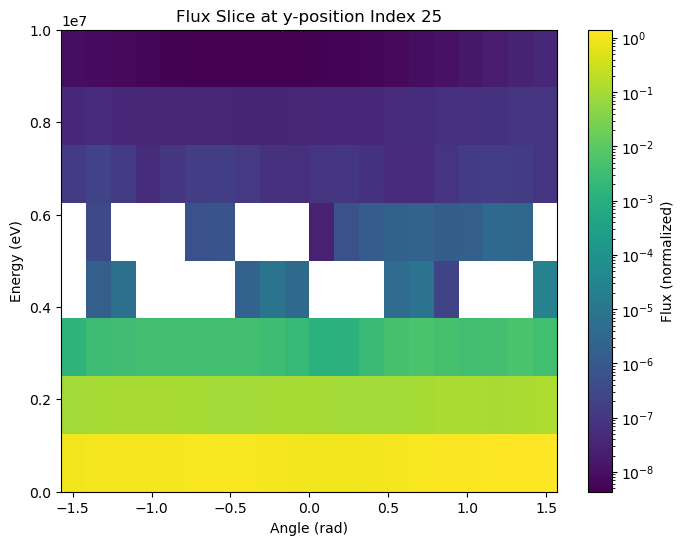

In [10]:
# np.abs(flux_normalized - reconstructed_flux)/flux_normalized
plot_flux(np.abs(flux_normalized - reconstructed_flux)/flux_normalized, energy_index, angle_index, mesh_index)

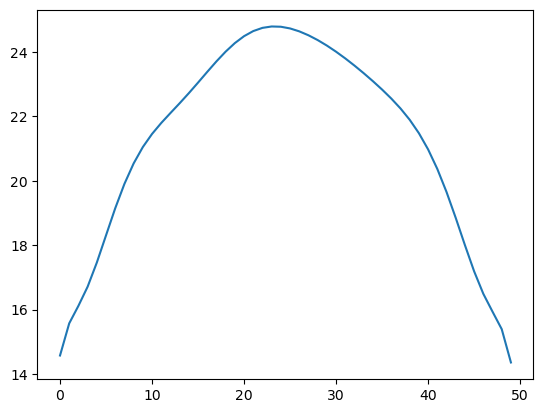

In [4]:
plt.plot(np.sum(reconstructed_flux, (1,2)))

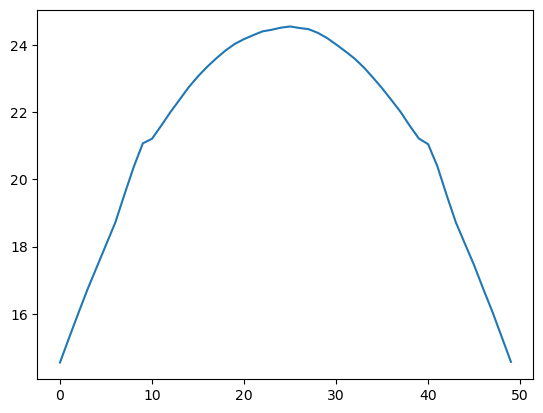

In [5]:
plt.plot(np.sum(flux_normalized, (1,2)))

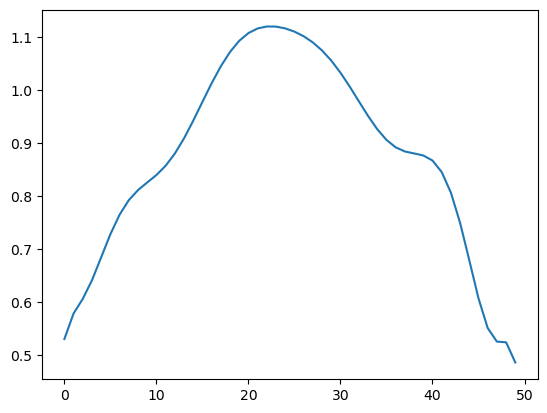

In [9]:
plt.plot(reconstructed_flux[:,2,0])

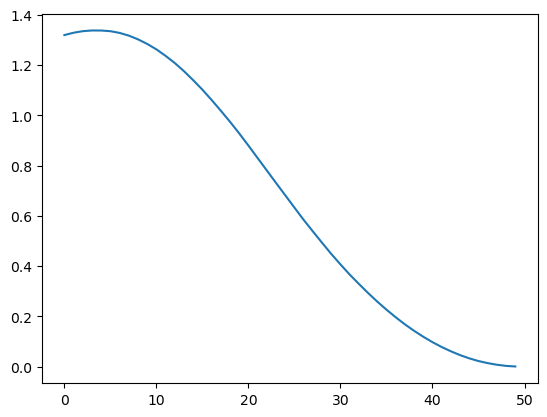

In [8]:
plt.plot(flux_normalized[:,2,0])